In [1]:
import mne
import numpy as np

In [2]:
raw = mne.io.read_raw_edf(r'C:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\final_course_project\data\SN001.edf', preload=True)
raw

Extracting EDF parameters from C:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\final_course_project\data\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_11628\3689000016.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(r'C:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\final_course_project\data\SN001.edf', preload=True)
C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_11628\3689000016.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(r'C:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\final_course_project\data\SN001.edf', preload=True)


Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


<RawEDF | SN001.edf, 8 x 6566400 (25650.0 s), ~400.8 MB, data loaded>

In [5]:
raw.info['ch_names']

['EEG F4-M1',
 'EEG C4-M1',
 'EEG O2-M1',
 'EEG C3-M2',
 'EMG chin',
 'EOG E1-M2',
 'EOG E2-M2',
 'ECG']

In [5]:
import re

In [23]:
ch_names = raw.info['ch_names']
eeg = [i for i in ch_names if re.match(r"\bEEG\w*\b", i)]
eog = [i for i in ch_names if re.match(r"\bEOG\w*\b", i)]
emg = [i for i in ch_names if re.match(r"\bEMG\w*\b", i)]
print(eeg)
print(eog)
print(emg)

['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']
['EOG E1-M2', 'EOG E2-M2']
['EMG chin']


In [25]:
def filter_polysomnography(signal, EEG_CHANNELS, EOG_CHANNELS, EMG_CHANNELS):
    raw_filtered = raw.filter(l_freq=0.16, h_freq=35, picks=EEG_CHANNELS)
    raw_filtered = raw_filtered.filter(l_freq=0.2, h_freq=10, picks=EOG_CHANNELS)
    raw_filtered = raw_filtered.filter(l_freq=10, h_freq=90, picks=EMG_CHANNELS)
    return raw_filtered

raw_filtered = filter_polysomnography(raw, eeg, eog, emg)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.16 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.16
- Lower transition bandwidth: 0.16 Hz (-6 dB cutoff frequency: 0.08 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 5281 samples (20.629 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain

In [85]:
from scipy.signal import iirnotch, filtfilt, butter, sosfiltfilt
from matplotlib import pyplot as plt
import numpy as np

In [86]:
def filter_signal(signal, Wn, fs):
    b, a = iirnotch(50, 30, fs)
    signal_notch = filtfilt(b, a, signal)
    sos = butter(2**3, Wn, btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(sos, signal_notch)

In [92]:
def only_bandpass(signal, Wn, fs):
    sos = butter(2**3, Wn, btype='bandpass', output='sos', fs=fs)
    return sosfiltfilt(sos, signal)

In [93]:
eeg = np.ravel(raw_filtered.get_data(picks='EEG C4-M1'))
eeg_filtered = filter_signal(eeg, [0.5, 35], raw.info['sfreq'])
eeg_onlybp = only_bandpass(eeg, [0.5, 35], raw.info['sfreq'])

In [104]:
start = 250*int(30*raw.info['sfreq'])
end = start + 10*int(30*raw.info['sfreq'])
cut_eeg = eeg[start:end]
cut_eeg_filtered = eeg_filtered[start:end]
cut_eeg_onlybp = eeg_onlybp[start:end]
t = np.linspace(0, 30, len(cut_eeg))

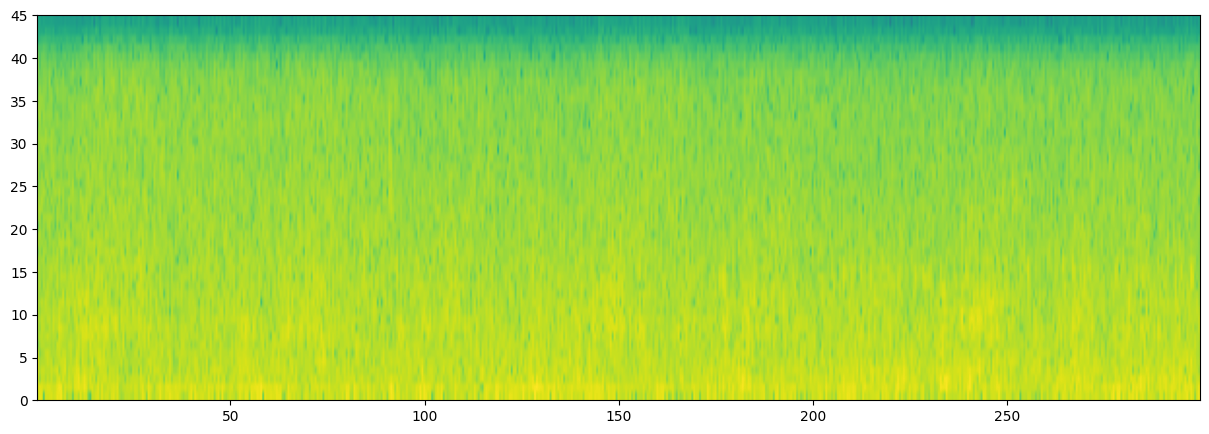

In [105]:
plt.figure(figsize=(15,5))
plt.specgram(cut_eeg, Fs=raw.info['sfreq'])
# plt.plot(t, cut_eeg_filtered, 'b')
# plt.plot(t, cut_eeg_onlybp, 'g')
plt.ylim([0,45])
plt.show()

In [18]:
np.array([raw.get_data()[0][:int(raw.info['sfreq']*30)],raw.get_data()[1][:int(raw.info['sfreq']*30)]]).T.shape

(7680, 2)

In [51]:
df.columns

Index(['Date', 'Time', 'Recording onset', 'Duration', 'Annotation',
       'Linked channel'],
      dtype='object')

## Sleep stages

In [81]:
import pandas as pd
import yasa
from matplotlib import pyplot as plt

In [82]:
def read_scoring_file(file_path):
    df = pd.read_csv(file_path, sep=', ')
    df['Annotation'] = df['Annotation'].str.rstrip(',')
    return df

def correct_stage(stg):
    if stg == 'W':
        stg_corrected = 0
    elif stg == 'N1':
        stg_corrected = 1
    elif stg == 'N2':
        stg_corrected = 2
    elif stg == 'N3':
        stg_corrected = 3
    elif stg == 'R':
        stg_corrected = 4
    else:
        stg_corrected = 'problem'
    return stg_corrected

def get_scoring(df):
    all_stages = ['W', 'N1', 'N2', 'N3', 'R']
    stages = df['Annotation'].apply(lambda x: x.split()[-1]).tolist()
    stages = [correct_stage(i) for i in stages if i in all_stages]
    return stages

C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_14876\2151287796.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=', ')
c:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\.venv\lib\site-packages\yasa\plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


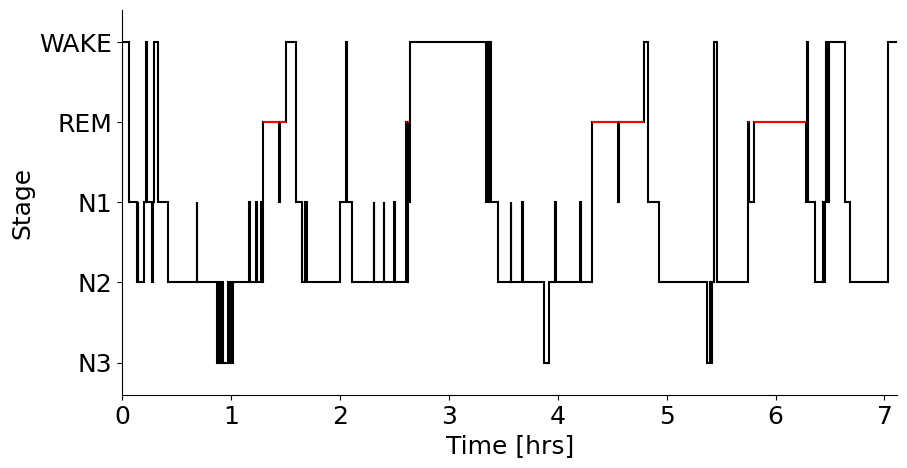

C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_14876\2151287796.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=', ')
c:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\.venv\lib\site-packages\yasa\plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


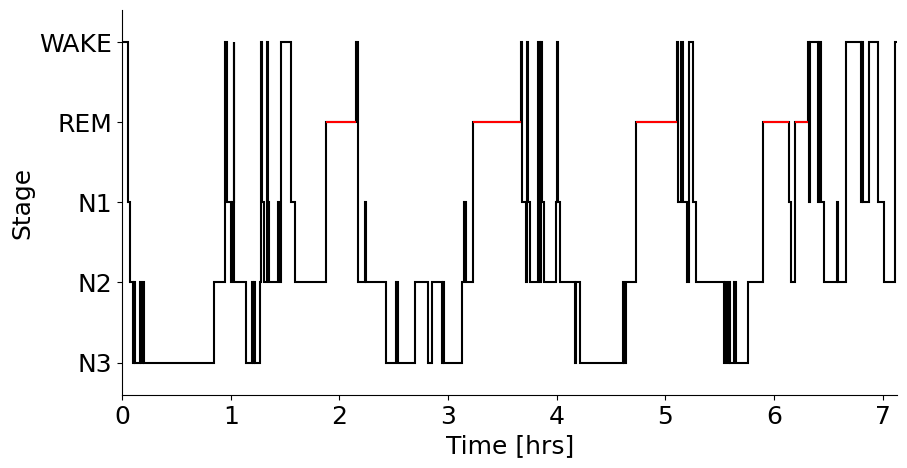

C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_14876\2151287796.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=', ')
c:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\.venv\lib\site-packages\yasa\plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


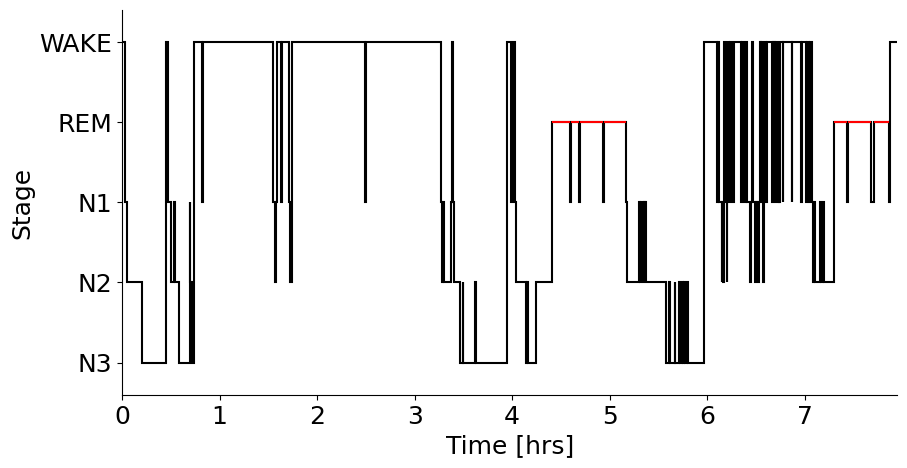

C:\Users\ayvazquez\AppData\Local\Temp\ipykernel_14876\2151287796.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, sep=', ')
c:\Users\ayvazquez\aylin\BCI_UNL_AllisonPeterson_course\.venv\lib\site-packages\yasa\plotting.py:89: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  freq_str = pd.tseries.frequencies.to_offset(pd.Timedelta(1 / sf_hypno, "S")).freqstr


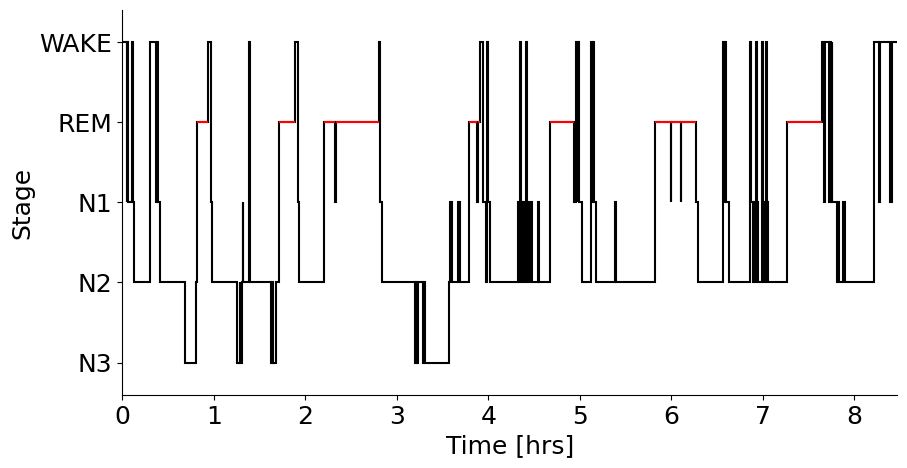

In [83]:
files_path = [r'data\SN001_sleepscoring.txt',
             r'data\SN002_sleepscoring.txt',
             r'data\SN003_sleepscoring.txt',
             r'data\SN004_sleepscoring.txt']

for file_path in files_path:
    df = read_scoring_file(file_path)
    stages = get_scoring(df)
    plt.figure(figsize=(10,5))
    yasa.plot_hypnogram(stages)
    plt.show()

In [78]:
plt.figure(figsize=(10,5))
yasa.plot_hypnogram(stages)